# Notebook for testing Adaptive Approximate Metropolis-Hastings

In [1]:
%run _init_notebook.ipynb
from approxmh.vae import VAE, AdaptiveVAETrainer
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, Funnel
from approxmh.samplers import AdaptiveVAESampler, MetropolisHastingsFilter, VAEGlobalMHFilter, VAEMetropolisWithinGibbsSampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.flow_trainer import AdaptiveFlowTrainer
from approxmh.pyro_samplers import NUTS
from approxmh.utilities import count_parameters, dataloader_from_tensor

device: cpu


2024-09-17 01:02:58.757967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 01:02:58.769033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 01:02:58.772341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 01:02:59.430752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


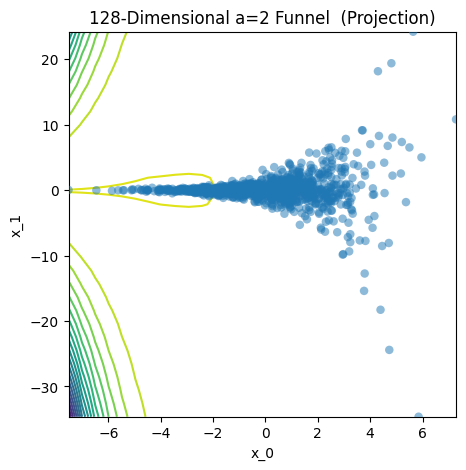

In [2]:
# target = create_serpentine(n_sections=3, section_height=1, section_width=1, device=device)
# target = create_random_gaussian_mixture(dim=2, n_components=10, variance_lim=(0.0001, 0.001), seed=39)
# target = IndependentMultivariateNormal(mean=torch.tensor([0., -5.]), std=torch.tensor(0.1))
target = Funnel(dim=128, a=2, device=device)
initial_sample = torch.distributions.Normal(loc=torch.tensor([1.0, 0.0]), scale=0.25).sample((200,))
# initial_sample = target.sample((500,))
visualize_distribution(target, sample_size=1_000, levels=20, plot_samples=True)
# plt.gca().scatter(*pl(initial_sample), zorder=4, alpha=0.9)

In [7]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(128, 192, 256),
    latent_dim=target.dim,
    device=device
)
vae_log_ml_estimator = lambda x : vae.iw_log_marginal_estimate(x, L=512, batch_L=64)
vae.log_prob = vae_log_ml_estimator
vae_trainer = AdaptiveVAETrainer(
    target=target,
    model=vae,
    model_log_likelihood=vae_log_ml_estimator,
    initial_sample=initial_sample,
    device=device,
    optimizer='adam',
    lr=5e-3,
    kl_annealing_batches=100,
    no_kl_penalty_batches=0
)

flow = RNVP(num_blocks=6, dim=target.dim, device=device)
flow_trainer = AdaptiveFlowTrainer(
    flow, target, device=device,
    forward_kl_factor=1,
    backward_kl_factor=1,
    optimizer='adam',
    lr=7e-4
)

print('# Flow parameters:', count_parameters(flow))
print('# VAE parameters:', count_parameters(vae))

# Flow parameters: 297216
# VAE parameters: 298880


In [8]:
n_train_samples = 4096
batch_size = 2056
train_samples = target.sample((n_train_samples,))
test_samples = target.sample((batch_size,))
train_loader = dataloader_from_tensor(train_samples, batch_size)

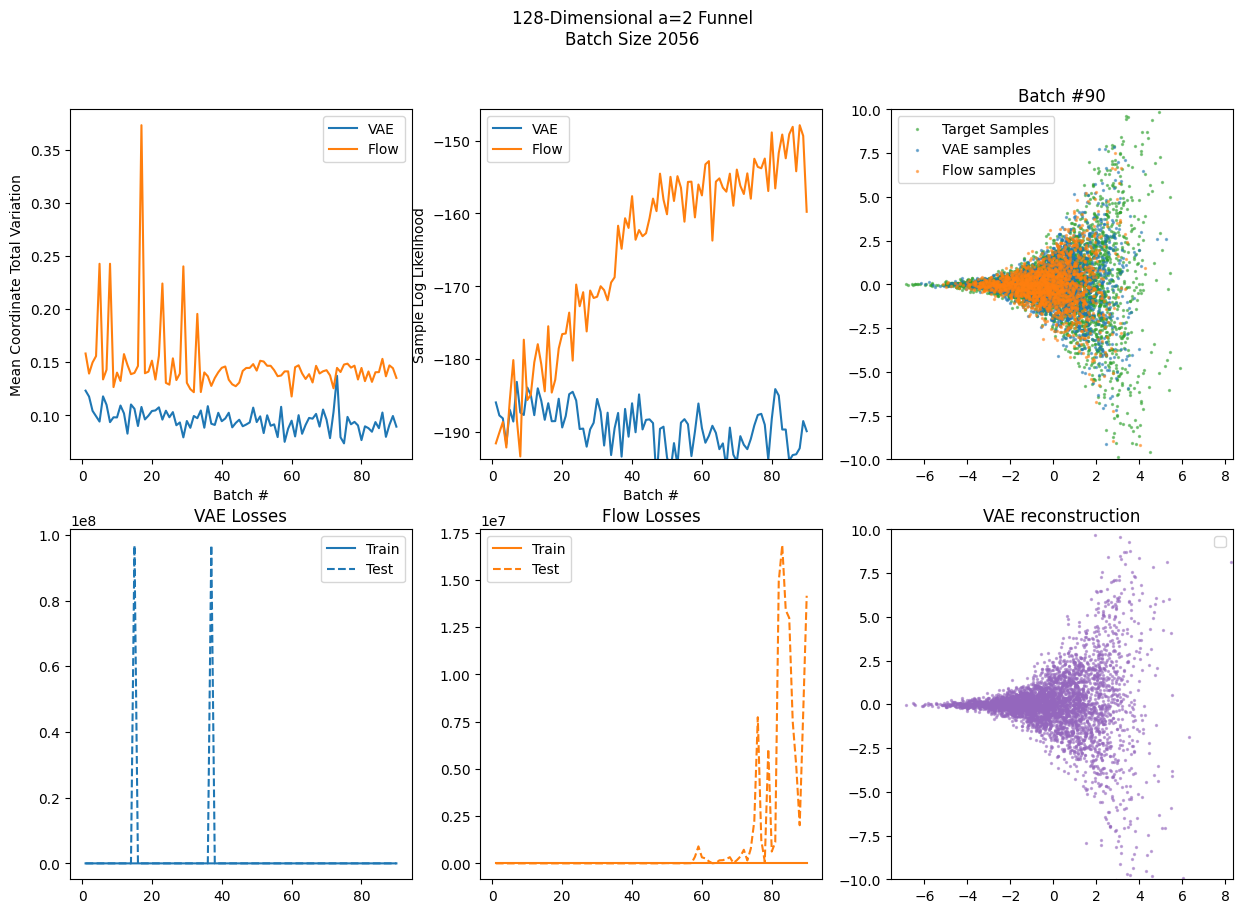

In [14]:
# %%time

def t_scatter(self, x, *args, **kwargs):
    proj_dims = (0, 1)
    self.scatter(*pl(x[:, proj_dims]), *args, s=2, alpha=0.5, **kwargs)
mpl.axes.Axes.t_scatter = t_scatter

def visualize_training(n_batches=300):
    plot_interval = 5
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('VAE', vae, vae_trainer, 'tab:blue'),
        ('Flow', flow, flow_trainer, 'tab:orange')
    ]
    
    
    test_logs = defaultdict(list)
    vae.train()
    flow.train()
    
    for batch_idx in range(1, n_batches + 1):
        need_plot = (batch_idx % plot_interval) == 0
        if need_plot:
            clear_output(wait=True)
            fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
            axs = axs.flatten()
            fig.suptitle(f'{target.friendly_name}\nBatch Size {batch_size}')
            axs[2].t_scatter(train_samples, label='Target Samples', color='tab:green')
            xlim = axs[2].get_xlim()
            ylim = axs[2].get_ylim()
        
        for model_name, model, trainer, color in models:
            # model_samples = trainer.sample_and_train(batch_size=batch_size)
            train_losses = []
            for x_train in train_loader:
                train_losses.append(trainer.train_on_sample(x_train))
            train_loss = sum(train_losses)
            model.eval()
            with torch.no_grad():
                model_samples = model.sample((batch_size,))
                test_loss = trainer.loss(test_samples)
            model.train()
            # print(model_name)
            test_logs[model_name + '_likelihood'].append(target.log_prob(model_samples).mean().item())
            test_logs[model_name + '_metric'].append(metric(train_samples, model_samples))
            test_logs[model_name + '_train_loss'].append(train_loss)
            test_logs[model_name + '_test_loss'].append(trainer.loss(test_samples).item())
            
            if need_plot:
                axs[2].t_scatter(model_samples, label=model_name+' samples', c=color)

        if need_plot:
            ax = axs[2]
            ax.set_title(f'Batch #{batch_idx}')
            ax.set_xlim(xlim)
            ax.set_ylim(-10, 10)
            
            ax = axs[0]
            ax.set_xlabel('Batch #')
            ax.set_ylabel(metric.name())
            for model_name, _, _,color in models:
                line = ax.plot(np.arange(1, batch_idx+1), test_logs[model_name + '_metric'], c=color, label=model_name)
            
            ax = axs[1]
            ax.set_xlabel('Batch #')
            ax.set_ylabel('Sample Log Likelihood')
            for model_name, _, _, color in models:
                ax.plot(np.arange(1, batch_idx+1), test_logs[model_name + '_likelihood'], c=color, label=model_name)
            ymin = min([test_logs[model_name + '_likelihood'][0] for model_name, _, _, _ in models])
            ymax = max([np.max(test_logs[model_name + '_likelihood']) for model_name, _, _, _ in models])
            padding = 0.05
            yrange = ymax - ymin
            ax.set_ylim(ymin - padding*yrange, ymax + padding*yrange)

            for i in range(len(models)):
                model_name, _, _, color = models[i]
                ax = axs[3 + i]
                ax.set_title(f'{model_name} Losses')
                ax.plot(np.arange(1, batch_idx+1), test_logs[model_name+'_train_loss'], c=color, label='Train')
                ax.plot(np.arange(1, batch_idx+1), test_logs[model_name+'_test_loss'], c=color, linestyle='--', label='Test')

            ax = axs[5]
            ax.set_title('VAE reconstruction')
            with torch.no_grad():
                ax.t_scatter(vae.reconstruct(train_samples), c='tab:purple')
            ax.set_xlim(xlim)
            ax.set_ylim(-10, 10)
            
            for ax in axs:
                ax.legend()            
            plt.show()
    
    vae.eval()
    flow.eval()

visualize_training(n_batches=90)

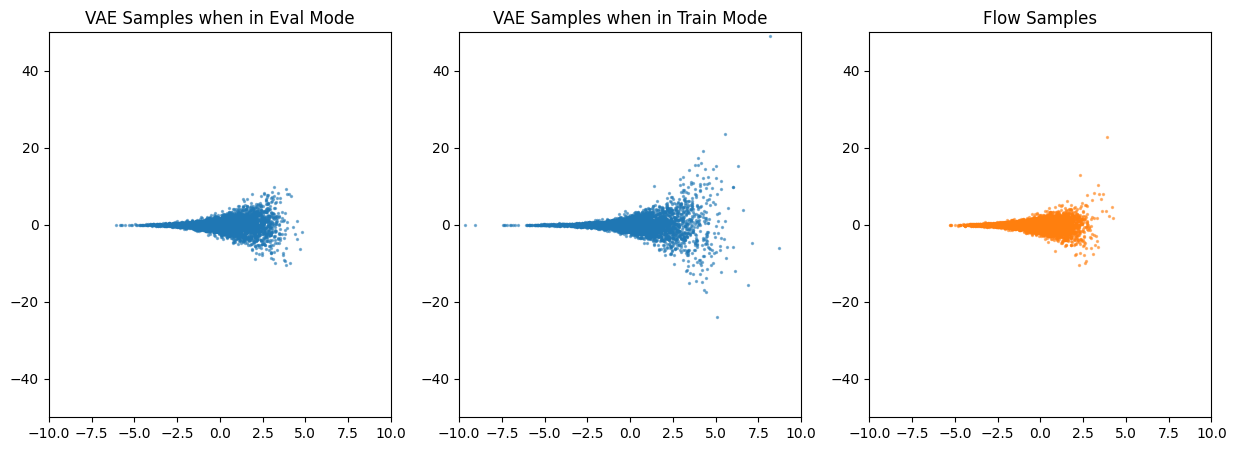

In [15]:
def train_eval_compare():
    n_samples = 5000
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('VAE Samples when in Eval Mode')
    vae.eval()
    ax.t_scatter(vae.sample((n_samples,)))
    ax = axs[1]
    ax.set_title('VAE Samples when in Train Mode')
    vae.train()
    ax.t_scatter(vae.sample((n_samples,)))
    ax = axs[2]
    ax.set_title('Flow Samples')
    ax.t_scatter(flow.sample((n_samples,)), c='tab:orange')
    for ax in axs:
        ax.set_xlim(-10, +10)
        ax.set_ylim(-50, +50)

train_eval_compare()

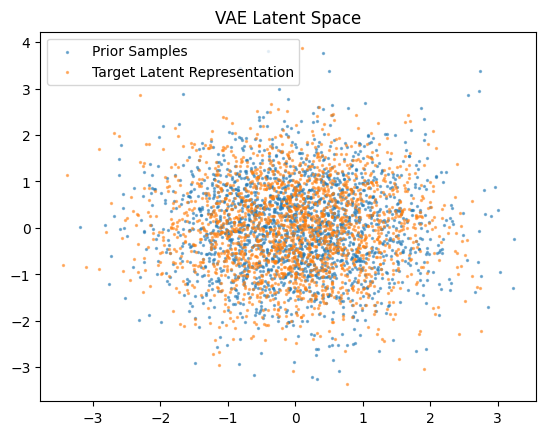

In [16]:
def compare_latent_representations():
    n_samples = 2000
    target_latent = vae.encode(target.sample((n_samples,)))
    fig, ax = plt.subplots()
    ax.set_title('VAE Latent Space')
    ax.t_scatter(vae.prior.sample((n_samples,)), label='Prior Samples')
    ax.t_scatter(target_latent, label='Target Latent Representation')
    ax.legend()

compare_latent_representations()

Sample: 100%|██████████████████████████████████████| 5000/5000 [00:03, 1621.30it/s, step size=4.00e-01, acc. prob=0.000]


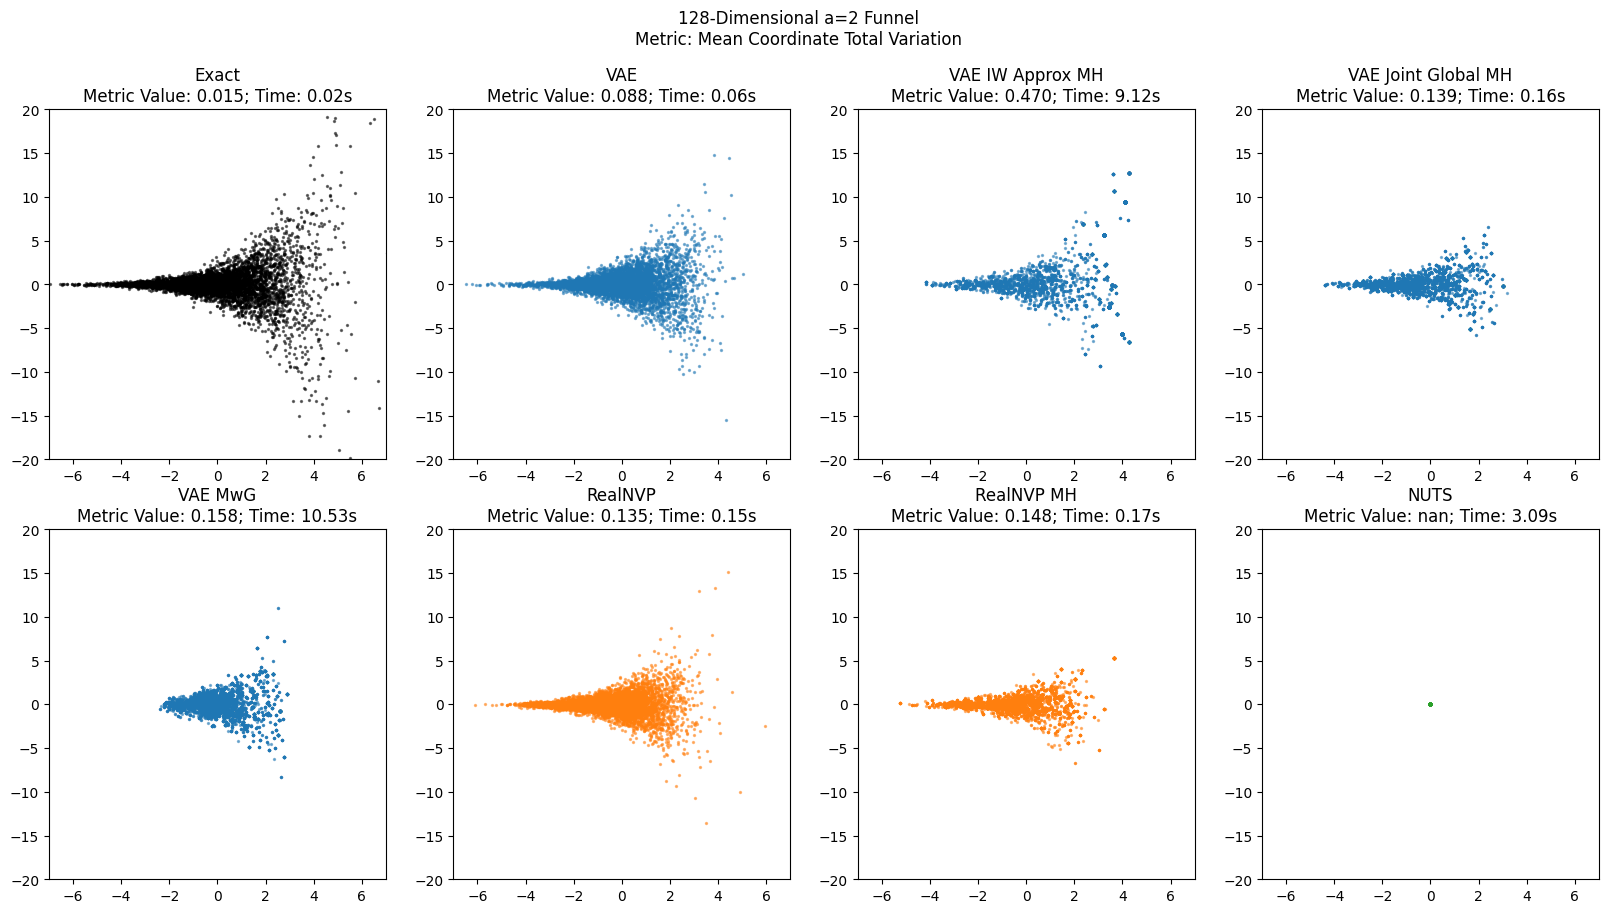

In [17]:
def compare_sampling_methods():
    vae.eval()
    flow.eval()
    
    n_samples = 5000
    target_samples = target.sample((n_samples,))
    metric_object = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    metric = lambda x: metric_object(target_samples, x)

    sampling_methods = [
        ('Exact', lambda n: target.sample((n,)), 'black'),
        ('VAE', lambda n: vae.sample((n,)), 'tab:blue'),
        ('VAE IW Approx MH', lambda n: MetropolisHastingsFilter(vae, target).apply(vae.sample((n,))), 'tab:blue'),
        ('VAE Joint Global MH', lambda n: VAEGlobalMHFilter(vae, target).apply(*vae.sample_joint((n,))), 'tab:blue'),
        ('VAE MwG', lambda n: VAEMetropolisWithinGibbsSampler(vae, target).sample(n), 'tab:blue'),
        ('RealNVP', lambda n: flow.sample((n,)), 'tab:orange'),
        ('RealNVP MH', lambda n: MetropolisHastingsFilter(flow, target).apply(flow.sample((n,))), 'tab:orange'),
        ('NUTS', lambda n: NUTS(torch.zeros((1, target.dim), device=device), target, n, 0, step_size=0.1, verbose=True)[:, 0], 'tab:green')
    ]
    n_methods = len(sampling_methods)

    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axs = axs.flatten()
    fig.suptitle(f'{target.friendly_name}\nMetric: {metric_object.name()}')
    for i in range(n_methods):
        name, sampler_func, color = sampling_methods[i]
        tic = time()
        samples = sampler_func(n_samples)
        toc = time()
        metric_value = metric(samples)
        ax = axs[i]
        ax.set_title(f'{name}\nMetric Value: {metric_value:0.3f}; Time: {toc-tic:0.2f}s')
        ax.t_scatter(samples, c=color)
        ax.set_xlim(-7, 7)
        ax.set_ylim(-20, 20)

compare_sampling_methods()

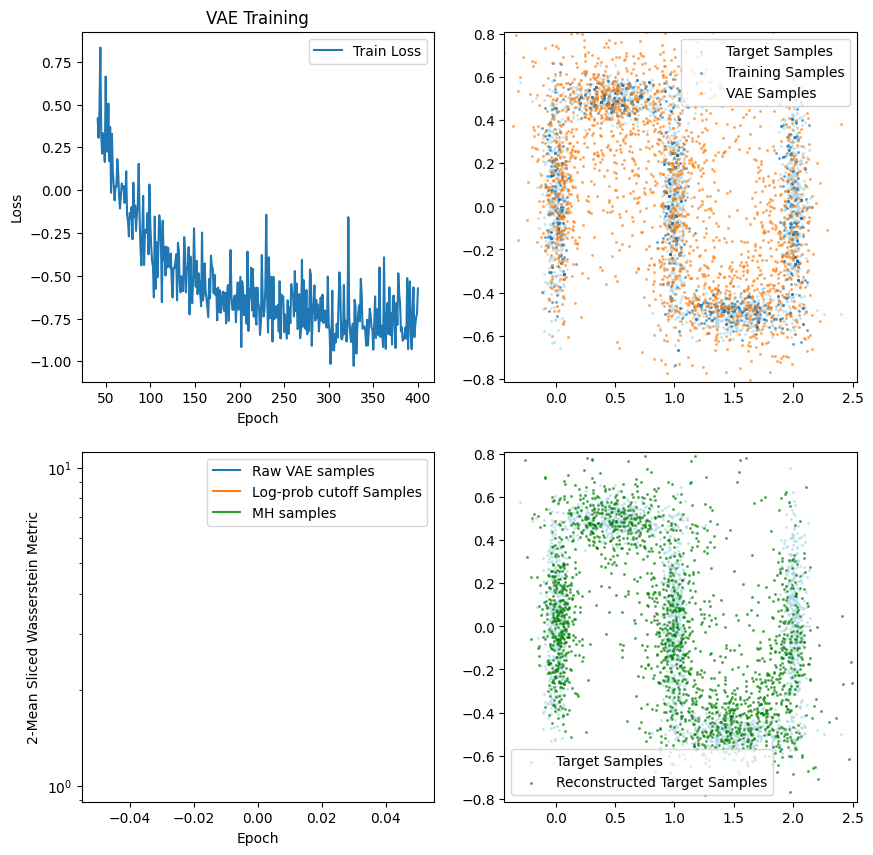

Epoch 400
	Train loss: -0.5741
	Validation loss: -0.9032
	Learning rate: 0.002
0 samples cut


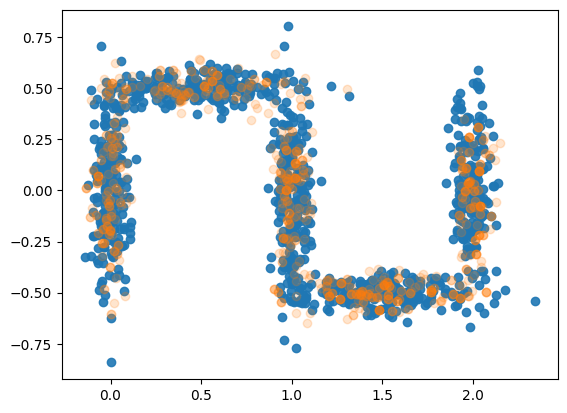

In [128]:
def retrain_and_sample():
    adaptive_sampler.retrain(
        optimizer='adam',
        lr=2e-3,
        n_epochs=400,
        kl_annealing_epochs=100,
        no_kl_penalty_epochs=20,
        plot_interval=20,
        clear_sample_history=True,
        warm_start=False
    )

    n_samples = 1000
    corrected_samples = adaptive_sampler.sample(n_samples)
    
    fig, ax = plt.subplots()
    ax.scatter(*pl(target.sample((n_samples,))), alpha=0.9)
    ax.scatter(*pl(corrected_samples), alpha=0.2)

retrain_and_sample()

In [25]:
test_tensor = torch.tensor([20.5203, -0.4022])
print(target(test_tensor), vae_ml_estimator(test_tensor))

tensor(-2895.1528) tensor([-6742.7866])


In [52]:
print(adaptive_sampler.probability_cutoff.min_log_prob)
tnsr = torch.tensor([0.0, 0.5])
target.log_prob(tnsr)

tensor(-7.6440)


tensor(-0.3721)